<h3>Download <a href="https://transitfeeds.com/p/mta/79/latest/download">New York Transit GTFS</a> feed by clicking the link</h3>

In [2]:
%fs ls "dbfs:/FileStore/tables/Roads/NYC_Roads"

path,name,size
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.cpg,NYC.cpg,5
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.dbf,NYC.dbf,23987280
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.prj,NYC.prj,145
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.sbn,NYC.sbn,1184156
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.sbx,NYC.sbx,48436
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.shp,NYC.shp,19335620
dbfs:/FileStore/tables/Roads/NYC_Roads/NYC.shx,NYC.shx,1004788


In [3]:
!pip install geopandas

In [4]:
import geopandas as gpd
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, count, lit, when, isnull,  lag, avg, lead, split, concat_ws
from math import radians, cos, sin, atan2
from pyspark.sql.window import Window

##GTFS Feed Files

<table>
<thead>
<tr>
<th>Filename</th>
<th>Required</th>
<th>Defines</th>
</tr>
</thead>
<tbody>
<tr>
<td>agency.txt</td>
<td><strong>Required</strong></td>
<td>One or more transit agencies that provide the data in this feed.</td>
</tr>
<tr>
<td>stops.txt</td>
<td><strong>Required</strong></td>
<td>Individual locations where vehicles pick up or drop off passengers.</td>
</tr>
<tr>
<td>routes.txt</td>
<td><strong>Required</strong></td>
<td>Transit routes. A route is a group of trips that are displayed to riders as a single service.</td>
</tr>
<tr>
<td>trips.txt</td>
<td><strong>Required</strong></td>
<td>Trips for each route. A trip is a sequence of two or more stops that occurs at specific time.</td>
</tr>
<tr>
<td>stop_times.txt</td>
<td><strong>Required</strong></td>
<td>Times that a vehicle arrives at and departs from individual stops for each trip.</td>
</tr>
<tr>
<td>calendar.txt</td>
<td><strong>Required</strong></td>
<td>Dates for service IDs using a weekly schedule. Specify when service starts and ends, as well as days of the week where service is available.</td>
</tr>
<tr>
<td>calendar_dates.txt</td>
<td>Optional</td>
<td>Exceptions for the service IDs defined in the **calendar.txt** file. If **calendar.txt** includes ALL dates of service, this file may be specified instead of **calendar.txt**.</td>
</tr>
<tr>
<td>fare_attributes.txt</td>
<td>Optional</td>
<td>Fare information for a transit organization's routes.</td>
</tr>
<tr>
<td>fare_rules.txt</td>
<td>Optional</td>
<td>Rules for applying fare information for a transit organization's routes.</td>
</tr>
<tr>
<td>shapes.txt</td>
<td>Optional</td>
<td>Rules for drawing lines on a map to represent a transit organization's routes.</td>
</tr>
<tr>
<td>frequencies.txt</td>
<td>Optional</td>
<td>Headway (time between trips) for routes with variable frequency of service.</td>
</tr>
<tr>
<td>transfers.txt</td>
<td>Optional</td>
<td>Rules for making connections at transfer points between routes.</td>
</tr>
<tr>
<td>feed_info.txt</td>
<td>Optional</td>
<td>Additional information about the feed itself, including publisher, version, and expiration information.</td>
</tr>
</tbody>
</table>

![Diagram](https://upload.wikimedia.org/wikipedia/commons/2/28/GTFS_class_diagram.svg)

In [6]:
stop_times = sqlContext.read.format('csv').options(header='true', inferSchema='true').load('/FileStore/tables/gtfs/nyc/stop_times.txt')
trips = sqlContext.read.format('csv').options(header= True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/trips.txt')
routes = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/routes.txt')
stops = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/stops.txt')
shapes = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/shapes.txt')
transfers = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/transfers.txt')
calendar = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/calendar.txt')
calendar_dates = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/calendar_dates.txt')
agency = sqlContext.read.format('csv').options(header=True, inferSchema = True).load('/FileStore/tables/gtfs/nyc/agency.txt')

In [7]:
display(agency)

agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone
MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234


<table>
<thead>
<tr>
<th>Field Name</th>
<th>Required</th>
<th>Details</th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<td>stop_id</td>
<td><strong>Required</strong></td>
<td>The <strong>stop_id</strong> field contains an ID that uniquely identifies a stop, station, or station entrance. Multiple routes may use the same stop. </td>
<td></td>
<td></td>
</tr>
<tr>
<td>stop_name</td>
<td><strong>Required</strong></td>
<td>The <strong>stop_name</strong> field contains the name of a stop, station, or station entrance. name that people will understand in the local and tourist vernacular.</td>
<td></td>
<td></td>
</tr>
<tr>
<td>stop_lat</td>
<td><strong>Required</strong></td>
<td>The <strong>stop_lat</strong> field contains the latitude of a stop, station, or station entrance. </td>
<td></td>
<td></td>
</tr>
<tr>
<td>stop_lon</td>
<td><strong>Required</strong></td>
<td>The <strong>stop_lon</strong> field contains the longitude of a stop, station, or station entrance. </td>
<td></td>
<td></td>
</tr>

</tbody>
</table>

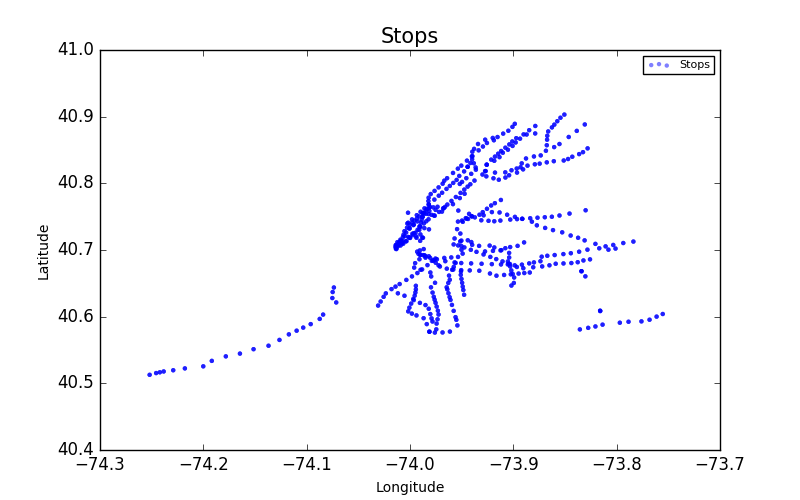

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
stops_pd = stops.toPandas()
# Plot the faciity clusters and cluster centroid
fig, ax = plt.subplots(figsize=[8, 5])
stops_scatter = ax.scatter(stops_pd['stop_lon'], stops_pd['stop_lat'], edgecolor='None', alpha=0.5, s=10)

ax.set_title('Stops', fontsize = 15)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize = 10)
ax.legend([stops_scatter], ['Stops'], loc='upper right', fontsize = 8)
display(fig)

<h3 id="transferstxt">transfers</h3>
<p>Trip planners normally calculate transfer points based on the relative proximity of stops in each route. For potentially ambiguous stop pairs, or transfers where you want to specify a particular choice, use transfers.txt to define additional rules for making connections between routes.</p>
<table>
<thead>
<tr>
<th>Field Name</th>
<th>Required</th>
<th>Details</th>
</tr>
</thead>
<tbody>
<tr>
<td>from_stop_id</td>
<td><strong>Required</strong></td>
<td>The <strong>from_stop_id</strong> field contains a stop ID that identifies a stop or station where a connection between routes begins. If the stop ID refers to a station that contains multiple stops, this transfer rule applies to all stops in that station.</td>
</tr>
<tr>
<td>to_stop_id</td>
<td><strong>Required</strong></td>
<td>The <strong>to_stop_id</strong> field contains a stop ID that identifies a stop or station where a connection between routes ends. If the stop ID refers to a station that contains multiple stops, this transfer rule applies to all stops in that station.</td>
</tr>
<tr>
<td>min_transfer_time</td>
<td>Optional</td>
<td>The min_transfer_time must be sufficient to permit a typical rider to move between the two stops. The min_transfer_time value must be entered in <strong>seconds</strong>, and must be a non-negative integer.</td>
</tr>
</tbody>
</table>
<p> Transfer should be enabled from the following : 
  <ul>
    <li>For a station which is a parent station, transfers between all it's child stations</li>
    <li></li>
    <li></li>
   </ul>
</p>

In [11]:
display(routes)

route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
1,MTA NYCT,1,Broadway - 7 Avenue Local,"Trains operate between 242 St in the Bronx and South Ferry in Manhattan, most times",1,http://web.mta.info/nyct/service/pdf/t1cur.pdf,EE352E,null
2,MTA NYCT,2,7 Avenue Express,"Trains operate between Wakefield-241 St, Bronx, and Flatbush Av-Brooklyn College, Brooklyn, at all times. Trains operate local in Bronx and Brooklyn. Trains operate express in Manhattan except late night when it operates local.",1,http://web.mta.info/nyct/service/pdf/t2cur.pdf,EE352E,
3,MTA NYCT,3,7 Avenue Express,"Trains operate between 148 St, 7 Av, Manhattan, and New Lots Av, Brooklyn, at all times except late nights. During late nights, trains operate only in Manhattan between 148 St, 7 Av and Times Square-42 St.",1,http://web.mta.info/nyct/service/pdf/t3cur.pdf,EE352E,null
4,MTA NYCT,4,Lexington Avenue Express,"Trains operate daily between Woodlawn/Jerome Av, Bronx, and Utica Av/Eastern Pkwy, Brooklyn, running express in Manhattan and Brooklyn. During late night and early morning hours, trains runs local in Manhattan and Brooklyn, and extends beyond Utica Av to New Lots/Livonia Avs, Brooklyn.",1,http://web.mta.info/nyct/service/pdf/t4cur.pdf,00933C,null
5,MTA NYCT,5,Lexington Avenue Express,"Weekdays daytime, most trains operate between either Dyre Av or 238 St-Nereid Av, Bronx, and Flatbush Av-Brooklyn College, Brooklyn. At all other times except during late nights, trains operate between Dyre Av, Bronx, and Bowling Green, Manhattan. During late nights trains operate only in the Bronx between Dyre Av and E 180 St/MorrisPark Av. Customers who ride during late night hours can transfer to 2 service at the E 180 St Station. At all times, trains operate express in Manhattan and Brooklyn. Weekdays, trains in the Bronx operate express from E 180 St to 149 St-3 Av during morning rush hours (from about 6 AM to 9 AM), and from 149 St-3 Av to E 180 St during the evening rush hours (from about 4 PM to 7 PM).",1,http://web.mta.info/nyct/service/pdf/t5cur.pdf,00933C,null
5X,MTA NYCT,5X,Lexington Avenue Express,"Weekdays daytime, most trains operate between either Dyre Av or 238 St-Nereid Av, Bronx, and Flatbush Av-Brooklyn College, Brooklyn. At all other times except during late nights, trains operate between Dyre Av, Bronx, and Bowling Green, Manhattan. During late nights trains operate only in the Bronx between Dyre Av and E 180 St/MorrisPark Av. Customers who ride during late night hours can transfer to 2 service at the E 180 St Station. At all times, trains operate express in Manhattan and Brooklyn. Weekdays, trains in the Bronx operate express from E 180 St to 149 St-3 Av during morning rush hours (from about 6 AM to 9 AM), and from 149 St-3 Av to E 180 St during the evening rush hours (from about 4 PM to 7 PM).",1,http://web.mta.info/nyct/service/pdf/t5cur.pdf,00933C,null
6,MTA NYCT,6,Lexington Avenue Local,"Local trains operate between Pelham Bay Park/Bruckner Expwy, Bronx, and Brooklyn Bridge/City Hall, Manhattan, at all times.",1,http://web.mta.info/nyct/service/pdf/t6cur.pdf,00933C,null
6X,MTA NYCT,6X,Lexington Avenue Express,"Express trains operate between Pelham Bay Park/Bruckner Expwy, Bronx, and Brooklyn Bridge/City Hall, Manhattan, weekday mornings toward Manhattan. Weekday afternoons and evenings, these trains operate express to the Bronx.",1,http://web.mta.info/nyct/service/pdf/t6cur.pdf,00A65C,null
7,MTA NYCT,7,Flushing Local,"Trains operate between Main St-Flushing, Queens, and 11th Av-34th St, at all times.",1,http://web.mta.info/nyct/service/pdf/t7cur.pdf,B933AD,null
7X,MTA NYCT,7X,Flushing Express,"Trains operate between Main St-Flushing, Queens, and 11th Av-34th St, Manhattan, weekday mornings toward Manhattan. Weekday afternoons and evenings, these trains operate express to Queens.",1,http://web.mta.info/nyct/service/pdf/t7cur.pdf,B933AD,null


In [12]:
display(trips.where("trip_id = 'ASP18GEN-1087-Weekday-00_037150_1..N03R'"))

route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
1,ASP18GEN-1087-Weekday-00,ASP18GEN-1087-Weekday-00_037150_1..N03R,Van Cortlandt Park - 242 St,0,null,1..N03R


In [13]:
display(calendar.where("service_id = 'ASP18GEN-1087-Weekday-00'"))

service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
ASP18GEN-1087-Weekday-00,1,1,1,1,1,0,0,20180625,20181102


In [14]:
display(stop_times.where("trip_id = 'ASP18GEN-1087-Weekday-00_037150_1..N03R'"))

trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:11:30,06:11:30,142N,1,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:14:00,06:14:00,139N,2,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:15:00,06:15:00,138N,3,null,1,1,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:16:00,06:16:00,137N,4,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:17:30,06:17:30,136N,5,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:18:30,06:18:30,135N,6,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:20:00,06:20:00,134N,7,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:21:30,06:21:30,133N,8,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:23:00,06:23:00,132N,9,null,0,0,null
ASP18GEN-1087-Weekday-00_037150_1..N03R,06:24:00,06:24:00,131N,10,null,0,0,null


<h2> Create All trips Data

In [16]:
all_trips = (stop_times.alias('a')
  .join(stops.alias('b'), col('a.stop_id') == col('b.stop_id'))
  .join(trips.alias('c'), col('a.trip_id') == col('c.trip_id'))
  .join(routes.alias('d'), col('c.route_id') == col('d.route_id'))
             .join(calendar.alias('e'), col('c.service_id') == col('e.service_id'))
  .select(
    [col('d.' +col_name)  for col_name in "route_short_name route_long_name route_color agency_id".split()] + 
    [col('c.' +col_name)  for col_name in "route_id  trip_id service_id	trip_headsign	direction_id".split()] + 
    [col('a.'+xx) for xx in "arrival_time	departure_time	stop_id	 stop_sequence".split()]  +  
    [col('b.' +col_name)  for col_name in "stop_name	stop_lat	stop_lon".split()] + 
    [col('e.' + col_name) for col_name in "monday sunday".split()]
  )
)

In [17]:
display(all_trips)

route_short_name,route_long_name,route_color,agency_id,route_id,trip_id,service_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,monday,sunday
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:06:00,00:06:00,101S,1,Van Cortlandt Park - 242 St,40.889248,-73.898583,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:07:30,00:07:30,103S,2,238 St,40.884667,-73.90087,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:09:00,00:09:00,104S,3,231 St,40.878856,-73.904834,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:10:30,00:10:30,106S,4,Marble Hill - 225 St,40.874561,-73.909831,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:12:00,00:12:00,107S,5,215 St,40.869444,-73.915279,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:13:00,00:13:00,108S,6,207 St,40.864621,-73.918822,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:14:30,00:14:30,109S,7,Dyckman St,40.860531,-73.925536,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:16:00,00:16:00,110S,8,191 St,40.855225,-73.929412,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:17:30,00:17:30,111S,9,181 St,40.849505,-73.933596,0,1
1,Broadway - 7 Avenue Local,EE352E,MTA NYCT,1,ASP18GEN-1037-Sunday-00_000600_1..S03R,ASP18GEN-1037-Sunday-00,South Ferry,1,00:19:30,00:19:30,112S,10,168 St - Washington Hts,40.840556,-73.940133,0,1


In [18]:
from datetime import datetime,timedelta

@udf('boolean')
def in_between(now, start, end):
  now = format_time(now)
  start = format_time(start)
  end = format_time(end)
  if start <= end:
      return start <= now < end
  else: # over midnight e.g., 23:30-04:15
      return start <= now or now < end
      
      
def format_time(t):
  FMT = '%H:%M:%S'
  h, m, s = t.split(':')
  if int(h) < 24:
    dt =  datetime.strptime(t, FMT)
  else:
    h = str(int(h) - 24)
    t = ":".join([h,m,s])
    dt = datetime.strptime(t, FMT)
    dt += timedelta(days=1)
  return dt
   

@udf('double')
def return_time_diff(time1, time2):
  time1 = format_time(time1)
  time2 = format_time(time2)
  tdelta = time1 - time2
  if tdelta.days < 0:
    tdelta = timedelta(days=0,
                seconds=tdelta.seconds, microseconds=tdelta.microseconds)
  return tdelta.total_seconds()


In [19]:
rush_hr_monday_trip_ids = all_trips.where("monday = 1 and stop_sequence = 1").withColumn("if_rush_hr", in_between(all_trips.departure_time, lit('16:00:00'), lit('19:00:00'))).where("if_rush_hr = True").select(col("trip_id"))

<ul>
  <li>There are 1529 trips on a Monday between 4pm and 7pm. </li>
  <li>Filter only Monday Rush hour trips from  all trips data </li>
</ul>

In [21]:
my_window = Window.partitionBy(["stop_id", "route_id", "trip_headsign"]).orderBy("departure_time")
rush_hr_trips = all_trips.alias("a").join(rush_hr_monday_trip_ids.alias("b"), col("a.trip_id") == col("b.trip_id")).select([col("a." + col_name) for col_name in all_trips.columns])

<h3>Find the frequency of each route at each station</h3>
<p>Frequency provides us <strong>wait times</strong> at each station</p>

In [23]:
#For each stop and route, find the last departed train
rush_hr_trips  = rush_hr_trips.withColumn("prev_departure", lag(rush_hr_trips.departure_time).over(my_window))
rush_hr_trips = rush_hr_trips.withColumn("prev_departure", when(isnull(rush_hr_trips.prev_departure), rush_hr_trips.arrival_time).otherwise(rush_hr_trips.prev_departure) )
#For the same stop and route find the last departed train in seconds
rush_hr_trips = rush_hr_trips.withColumn("last_train_departure_in_seconds", return_time_diff(rush_hr_trips.departure_time, rush_hr_trips.prev_departure))

display(rush_hr_trips.where("stop_id == 'D27S'").orderBy("route_id", "departure_time"))

route_short_name,route_long_name,route_color,agency_id,route_id,trip_id,service_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,monday,sunday,prev_departure,last_train_departure_in_seconds
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_096350_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,16:44:30,16:44:30,D27S,14,Parkside Av,40.655292,-73.961495,1,0,16:44:30,0.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_097350_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,16:52:00,16:52:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,16:44:30,450.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_098150_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:00:00,17:00:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,16:52:00,480.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_098950_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:08:00,17:08:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:00:00,480.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_099450_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:17:00,17:17:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:08:00,540.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_100400_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:24:30,17:24:30,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:17:00,450.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_100800_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:31:00,17:31:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:24:30,390.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_101800_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:38:30,17:38:30,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:31:00,450.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_102200_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:45:00,17:45:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:38:30,390.0
Q,Broadway Express,FCCC0A,MTA NYCT,Q,BSP18GEN-Q061-Weekday-00_102950_Q..S16R,BSP18GEN-Q061-Weekday-00,Coney Island - Stillwell Av,1,17:51:00,17:51:00,D27S,14,Parkside Av,40.655292,-73.961495,1,0,17:45:00,360.0


<h3> Find the Waiting times at each station for each route</h3>
<p><strong>Waiting time for a route at a stop is the average frequency of wait for the trips in that route at that stop

In [25]:
@udf(ArrayType(StringType()))
def return_list(*arg):
  return list(arg)

waiting_times = (rush_hr_trips.where("last_train_departure_in_seconds <> 0")
         .groupby(["stop_id", "stop_lat", "stop_lon", "route_id", "trip_headsign", "agency_id"])
         .agg(avg("last_train_departure_in_seconds").alias("wait_time"))
                )

waiting_times = (waiting_times.alias("a")
                 .join(stops.alias("b"), col("a.stop_id") == col("b.stop_id"), how="left")
                 .select([col("a." + col_name) for col_name in waiting_times.columns] + [col("b.parent_station")])
                )

waiting_times = (waiting_times
                 .withColumn("parent_station", when(isnull("parent_station"), waiting_times.stop_id).otherwise(waiting_times.parent_station))
                 .withColumn("node_id", return_list(waiting_times.stop_id, waiting_times.route_id, waiting_times.trip_headsign, waiting_times.agency_id))
                )
display(waiting_times)

stop_id,stop_lat,stop_lon,route_id,trip_headsign,agency_id,wait_time,parent_station,node_id
230S,40.706821,-74.0091,3,New Lots Av,MTA NYCT,457.82608695652175,230,"List(230S, 3, New Lots Av, MTA NYCT)"
G34N,40.688873,-73.96007,G,Court Sq,MTA NYCT,477.14285714285717,G34,"List(G34N, G, Court Sq, MTA NYCT)"
G28N,40.724635,-73.951277,G,Court Sq,MTA NYCT,477.14285714285717,G28,"List(G28N, G, Court Sq, MTA NYCT)"
720N,40.742216,-73.948916,7X,Flushing - Main St,MTA NYCT,348.0,720,"List(720N, 7X, Flushing - Main St, MTA NYCT)"
A19N,40.791642,-73.964696,C,168 St,MTA NYCT,605.2941176470588,A19,"List(A19N, C, 168 St, MTA NYCT)"
D26N,40.661614,-73.962246,B,Bedford Park Blvd,MTA NYCT,600.0,D26,"List(D26N, B, Bedford Park Blvd, MTA NYCT)"
S24N,40.583591,-74.103338,SI,St George,MTA NYCT,942.0,S24,"List(S24N, SI, St George, MTA NYCT)"
111S,40.849505,-73.933596,1,South Ferry,MTA NYCT,249.7674418604651,111,"List(111S, 1, South Ferry, MTA NYCT)"
A55N,40.675377,-73.872106,C,168 St,MTA NYCT,610.5882352941177,A55,"List(A55N, C, 168 St, MTA NYCT)"
L26S,40.664038,-73.900571,L,Canarsie - Rockaway Pkwy,MTA NYCT,231.33333333333334,L26,"List(L26S, L, Canarsie - Rockaway Pkwy, MTA NYCT)"


<h3>Create Transfers between stations</h3>
<ul>Transfers should be formed between the following: 
  <li>Stations within the same parent station, specifically between each route-direction-stop combination </li>
  <li>Other stations mentioned in the tranfers file</li>
</ul>

In [27]:
transfer_times = (transfers.alias("a")
        .join(stops.alias("b"), col("a.from_stop_id") == col("b.parent_station"), how="left")
        .join(stops.alias("c"), col("a.to_stop_id") == col("c.parent_station"), how="left")
        .select(
          [
            col("a.*"),
           col("b.stop_id").alias("src"), 
           col("c.stop_id").alias("dst")
           ]
        ))
#If parent is not available, the stop id is the soruce 
transfer_times = (
  transfer_times
  .withColumn("src", when(isnull(transfer_times.src), transfer_times.from_stop_id).otherwise(transfer_times.src))
  .withColumn("dst", when(isnull(transfer_times.dst), transfer_times.to_stop_id).otherwise(transfer_times.dst))
                 )
transfer_times = transfer_times.withColumn("min_transfer_time",  when(transfer_times.src == transfer_times.dst, 0).otherwise(transfer_times.min_transfer_time))
display(transfer_times)

from_stop_id,to_stop_id,transfer_type,min_transfer_time,src,dst
101,101,2,0,101S,101S
101,101,2,180,101S,101N
101,101,2,180,101N,101S
101,101,2,0,101N,101N
103,103,2,0,103S,103S
103,103,2,180,103S,103N
103,103,2,180,103N,103S
103,103,2,0,103N,103N
104,104,2,0,104S,104S
104,104,2,180,104S,104N


<h3>Calculate Actual Transfer Times</h3>
Actual transfers should take into time the <strong>transfer time</strong> between stations and also the<strong> waiting time </strong>for the next train

In [29]:
total_transfer_times = (transfer_times.alias("a")
                        .join(waiting_times.alias("b"), col("a.src") == col("b.stop_id"))
                        .join(waiting_times.alias("c"), col("a.dst") == col("c.stop_id"))
                        .where("b.node_id <> c.node_id")
                        .select([ 
                          col("a.src").alias("src_stop_id"), 
                          col("a.dst").alias("dst_stop_id"),
                          col("a.min_transfer_time"),
                          col("b.node_id").alias("src_node"), 
                          col("b.stop_lat").alias("src_lat"),
                          col("b.stop_lon").alias("src_lon"), 
                          col("c.stop_lat").alias("dst_lat"),
                          col("c.stop_lon").alias("dst_lon"),
                          col("c.node_id").alias("dst_node"),
                          col("b.route_id").alias("src_route_id"), 
                          col("b.trip_headsign").alias("src_trip_headsign"),
                          col("c.route_id").alias("dst_route_id"), 
                          col("c.trip_headsign").alias("dst_trip_headsign"),
                          col("c.wait_time")
                        ])
                       )
total_transfer_times = total_transfer_times.withColumn("total_tranfer_time", total_transfer_times.min_transfer_time + total_transfer_times.wait_time)
display(total_transfer_times)

src_stop_id,dst_stop_id,min_transfer_time,src_node,src_lat,src_lon,dst_lat,dst_lon,dst_node,src_route_id,src_trip_headsign,dst_route_id,dst_trip_headsign,wait_time,total_tranfer_time
715N,715S,180,"List(715N, 7, Flushing - Main St, MTA NYCT)",40.743781,-73.924016,40.743781,-73.924016,"List(715S, 7, 34 St - 11 Av, MTA NYCT)",7,Flushing - Main St,7,34 St - 11 Av,166.40625,346.40625
715N,715S,180,"List(715N, 7, Mets - Willets Point, MTA NYCT)",40.743781,-73.924016,40.743781,-73.924016,"List(715S, 7, 34 St - 11 Av, MTA NYCT)",7,Mets - Willets Point,7,34 St - 11 Av,166.40625,346.40625
D26S,D26S,0,"List(D26S, Q, Coney Island - Stillwell Av, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, B, Brighton Beach, MTA NYCT)",Q,Coney Island - Stillwell Av,B,Brighton Beach,491.42857142857144,491.42857142857144
D26S,D26S,0,"List(D26S, B, Brighton Beach, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, Q, Coney Island - Stillwell Av, MTA NYCT)",B,Brighton Beach,Q,Coney Island - Stillwell Av,405.6,405.6
D26N,D26S,180,"List(D26N, B, Bedford Park Blvd, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, Q, Coney Island - Stillwell Av, MTA NYCT)",B,Bedford Park Blvd,Q,Coney Island - Stillwell Av,405.6,585.6
D26N,D26S,180,"List(D26N, B, Bedford Park Blvd, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, B, Brighton Beach, MTA NYCT)",B,Bedford Park Blvd,B,Brighton Beach,491.42857142857144,671.4285714285714
D26N,D26S,180,"List(D26N, Q, 96 St, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, Q, Coney Island - Stillwell Av, MTA NYCT)",Q,96 St,Q,Coney Island - Stillwell Av,405.6,585.6
D26N,D26S,180,"List(D26N, Q, 96 St, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, B, Brighton Beach, MTA NYCT)",Q,96 St,B,Brighton Beach,491.42857142857144,671.4285714285714
D26N,D26S,180,"List(D26N, FS, Franklin Av, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, Q, Coney Island - Stillwell Av, MTA NYCT)",FS,Franklin Av,Q,Coney Island - Stillwell Av,405.6,585.6
D26N,D26S,180,"List(D26N, FS, Franklin Av, MTA NYCT)",40.661614,-73.962246,40.661614,-73.962246,"List(D26S, B, Brighton Beach, MTA NYCT)",FS,Franklin Av,B,Brighton Beach,491.42857142857144,671.4285714285714


<h3>Segment Travel Time per route</h3>
STEPS:
<ul>
  <li>For each trip, caculate the time taken between stops</li>
  <li>Aggregate the segment trip times to find segment travel times by route</li>
</ul>

In [31]:
my_window = Window.partitionBy("trip_id").orderBy("stop_sequence")
rush_hr_trips = rush_hr_trips.withColumn("src_node", return_list(rush_hr_trips.stop_id, rush_hr_trips.route_id, rush_hr_trips.trip_headsign, rush_hr_trips.agency_id))
rush_hr_trips = rush_hr_trips.withColumn("dst_node", lead(rush_hr_trips.src_node).over(my_window))
rush_hr_trips  = rush_hr_trips.withColumn("next_arrival", lead(rush_hr_trips.arrival_time).over(my_window))
rush_hr_trips  = rush_hr_trips.withColumn("dst_stop_id", lead(rush_hr_trips.stop_id).over(my_window))
#Last stop in a trip is not needed since it is already added as a destination node
rush_hr_trips = rush_hr_trips.where(rush_hr_trips.next_arrival.isNotNull())
rush_hr_trips = rush_hr_trips.withColumn("segment_trip_time", return_time_diff(rush_hr_trips.next_arrival, rush_hr_trips.arrival_time) )
display(rush_hr_trips)

route_short_name,route_long_name,route_color,agency_id,route_id,trip_id,service_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,monday,sunday,prev_departure,last_train_departure_in_seconds,src_node,dst_node,next_arrival,segment_trip_time,dst_stop_id,dst_lat,dst_lon
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:42:00,17:42:00,301S,1,Harlem - 148 St,40.82388,-73.93647,1,0,17:35:00,420.0,"List(301S, 3, New Lots Av, MTA NYCT)","List(302S, 3, New Lots Av, MTA NYCT)",17:44:00,120.0,302S,40.820421,-73.936245
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:44:00,17:44:00,302S,2,145 St,40.820421,-73.936245,1,0,17:37:00,420.0,"List(302S, 3, New Lots Av, MTA NYCT)","List(224S, 3, New Lots Av, MTA NYCT)",17:46:30,150.0,224S,40.814229,-73.94077
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:46:30,17:46:30,224S,3,135 St,40.814229,-73.94077,1,0,17:39:30,420.0,"List(224S, 3, New Lots Av, MTA NYCT)","List(225S, 3, New Lots Av, MTA NYCT)",17:48:30,120.0,225S,40.807754,-73.945495
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:48:30,17:48:30,225S,4,125 St,40.807754,-73.945495,1,0,17:41:30,420.0,"List(225S, 3, New Lots Av, MTA NYCT)","List(226S, 3, New Lots Av, MTA NYCT)",17:50:00,90.0,226S,40.802098,-73.949625
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:50:00,17:50:00,226S,5,116 St,40.802098,-73.949625,1,0,17:43:00,420.0,"List(226S, 3, New Lots Av, MTA NYCT)","List(227S, 3, New Lots Av, MTA NYCT)",17:51:00,60.0,227S,40.799075,-73.951822
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:51:00,17:51:00,227S,6,Central Park North (110 St),40.799075,-73.951822,1,0,17:44:00,420.0,"List(227S, 3, New Lots Av, MTA NYCT)","List(120S, 3, New Lots Av, MTA NYCT)",17:56:00,300.0,120S,40.793919,-73.972323
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:56:00,17:56:00,120S,7,96 St,40.793919,-73.972323,1,0,17:49:00,420.0,"List(120S, 3, New Lots Av, MTA NYCT)","List(123S, 3, New Lots Av, MTA NYCT)",17:59:00,180.0,123S,40.778453,-73.98197
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,17:59:00,17:59:00,123S,8,72 St,40.778453,-73.98197,1,0,17:52:00,420.0,"List(123S, 3, New Lots Av, MTA NYCT)","List(127S, 3, New Lots Av, MTA NYCT)",18:04:00,300.0,127S,40.75529,-73.987495
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,18:04:00,18:04:00,127S,9,Times Sq - 42 St,40.75529,-73.987495,1,0,17:57:00,420.0,"List(127S, 3, New Lots Av, MTA NYCT)","List(128S, 3, New Lots Av, MTA NYCT)",18:05:00,60.0,128S,40.750373,-73.991057
3,7 Avenue Express,EE352E,MTA NYCT,3,ASP18GEN-3086-Weekday-00_106200_3..S01R,ASP18GEN-3086-Weekday-00,New Lots Av,1,18:05:00,18:05:00,128S,10,34 St - Penn Station,40.750373,-73.991057,1,0,17:58:00,420.0,"List(128S, 3, New Lots Av, MTA NYCT)","List(132S, 3, New Lots Av, MTA NYCT)",18:08:00,180.0,132S,40.737826,-74.000201


In [32]:
segment_travel_times = (
  rush_hr_trips
  .groupby(["stop_id", "dst_stop_id", "src_node", "dst_node"])
         .agg(avg("segment_trip_time").alias("time_cost"))
                )
display(segment_travel_times)

stop_id,dst_stop_id,src_node,dst_node,time_cost
D43N,B23N,"List(D43N, D, Norwood - 205 St, MTA NYCT)","List(B23N, D, Norwood - 205 St, MTA NYCT)",240.0
D16N,D15N,"List(D16N, M, Forest Hills - 71 Av, MTA NYCT)","List(D15N, M, Forest Hills - 71 Av, MTA NYCT)",150.0
D35S,D37S,"List(D35S, Q, Coney Island - Stillwell Av, MTA NYCT)","List(D37S, Q, Coney Island - Stillwell Av, MTA NYCT)",176.53846153846155
245N,244N,"List(245N, 5X, Eastchester - Dyre Av, MTA NYCT)","List(244N, 5X, Eastchester - Dyre Av, MTA NYCT)",90.0
R14S,R15S,"List(R14S, W, Whitehall St, MTA NYCT)","List(R15S, W, Whitehall St, MTA NYCT)",120.0
D16S,D17S,"List(D16S, B, Brighton Beach, MTA NYCT)","List(D17S, B, Brighton Beach, MTA NYCT)",115.9090909090909
F12S,D15S,"List(F12S, M, Middle Village - Metropolitan Av, MTA NYCT)","List(D15S, M, Middle Village - Metropolitan Av, MTA NYCT)",120.0
A22N,A21N,"List(A22N, B, 145 St, MTA NYCT)","List(A21N, B, 145 St, MTA NYCT)",90.0
R23N,R22N,"List(R23N, R, Forest Hills - 71 Av, MTA NYCT)","List(R22N, R, Forest Hills - 71 Av, MTA NYCT)",104.34782608695652
118N,117N,"List(118N, 1, Van Cortlandt Park - 242 St, MTA NYCT)","List(117N, 1, Van Cortlandt Park - 242 St, MTA NYCT)",60.0


In [33]:
segment_travel_times = (segment_travel_times.alias("a")
                .join(stops.alias("b"), col("a.stop_id") == col("b.stop_id"))
                .join(stops.alias("c"), col("a.dst_stop_id") == col("c.stop_id"))
                .select([
                  col("a.src_node").alias("src"),
                  col("a.dst_node").alias("dst"),
                  col("a.stop_id").alias("src_stop_id"),
                  col("a.dst_stop_id").alias("dst_stop_id"),
                  col("b.stop_lon").alias("src_lon"),
                 col("b.stop_lat").alias("src_lat"),
                 col("c.stop_lon").alias("dst_lon"),
                 col("c.stop_lat").alias("dst_lat"),
                  col("a.time_cost")
                ]
               ))
display(segment_travel_times)

src,dst,src_stop_id,dst_stop_id,src_lon,src_lat,dst_lon,dst_lat,time_cost
"List(D43N, D, Norwood - 205 St, MTA NYCT)","List(B23N, D, Norwood - 205 St, MTA NYCT)",D43N,B23N,-73.981233,40.577422,-73.983765,40.588841,240.0
"List(D16N, M, Forest Hills - 71 Av, MTA NYCT)","List(D15N, M, Forest Hills - 71 Av, MTA NYCT)",D16N,D15N,-73.984569,40.754222,-73.981329,40.758663,150.0
"List(D35S, Q, Coney Island - Stillwell Av, MTA NYCT)","List(D37S, Q, Coney Island - Stillwell Av, MTA NYCT)",D35S,D37S,-73.957734,40.60867,-73.955929,40.5993,176.53846153846155
"List(245N, 5X, Eastchester - Dyre Av, MTA NYCT)","List(244N, 5X, Eastchester - Dyre Av, MTA NYCT)",245N,244N,-73.948959,40.645098,-73.949575,40.650843,90.0
"List(R14S, W, Whitehall St, MTA NYCT)","List(R15S, W, Whitehall St, MTA NYCT)",R14S,R15S,-73.980658,40.764664,-73.984139,40.759901,120.0
"List(D16S, B, Brighton Beach, MTA NYCT)","List(D17S, B, Brighton Beach, MTA NYCT)",D16S,D17S,-73.984569,40.754222,-73.987823,40.749719,115.9090909090909
"List(F12S, M, Middle Village - Metropolitan Av, MTA NYCT)","List(D15S, M, Middle Village - Metropolitan Av, MTA NYCT)",F12S,D15S,-73.975224,40.760167,-73.981329,40.758663,120.0
"List(A22N, B, 145 St, MTA NYCT)","List(A21N, B, 145 St, MTA NYCT)",A22N,A21N,-73.97641,40.775594,-73.972143,40.781433,90.0
"List(R23N, R, Forest Hills - 71 Av, MTA NYCT)","List(R22N, R, Forest Hills - 71 Av, MTA NYCT)",R23N,R22N,-74.001775,40.719527,-73.997702,40.724329,104.34782608695652
"List(118N, 1, Van Cortlandt Park - 242 St, MTA NYCT)","List(117N, 1, Van Cortlandt Park - 242 St, MTA NYCT)",118N,117N,-73.966847,40.803967,-73.96411,40.807722,60.0


In [34]:
edges = (segment_travel_times
         .select(
           [ concat_ws('-', col("src")).alias("src") , 
                   concat_ws('-', col("dst")).alias("dst"),  
                   col("src_stop_id"),
                   col("dst_stop_id"),
                   col("src_lon"),
                   col("src_lat"),
                    col("dst_lon"), 
                    col("dst_lat"), 
                    col("time_cost"),
                   lit(False).alias("modal_station")
                  ]          
         )
         .union(total_transfer_times
               
                .select(
                  [concat_ws('-', col("src_node")) .alias("src"), 
                   concat_ws('-', col("dst_node")).alias("dst"),  
                   col("src_stop_id"),
                   col("dst_stop_id"),
                   col("src_lon"),
                   col("src_lat"),
                    col("dst_lon"), 
                    col("dst_lat"), 
                    col("total_tranfer_time").alias("time_cost") ,
                   lit(False).alias("modal_station")
                  ])
               )
         .union(waiting_times
               .select([
                 col("parent_station").alias("src"),
                        concat_ws('-', col("node_id")).alias("dst"),
                        col("parent_station").alias("src_stop_id"),
                        col("parent_station").alias("dst_stop_id"),
                        col("stop_lon").alias("src_lon"),
                        col("stop_lat").alias("src_lat"),
                        col("stop_lon").alias("dst_lon"),
                        col("stop_lat").alias("dst_lat"),
                        (lit(180) + col("wait_time")).alias("time_cost"),
                        lit(True).alias("modal_station")
                       ]
                      ))
         .union(waiting_times
               .select([
                 concat_ws('-', col("node_id")).alias("src"),
                        col("parent_station").alias("dst"),
                        col("parent_station").alias("src_stop_id"),
                        col("parent_station").alias("dst_stop_id"),
                        col("stop_lon").alias("src_lon"),
                        col("stop_lat").alias("src_lat"),
                        col("stop_lon").alias("dst_lon"),
                        col("stop_lat").alias("dst_lat"),
                        lit(180).alias("time_cost"),
                        lit(False).alias("modal_station")
                       ]
                      ))
        )

display(edges)

src,dst,src_stop_id,dst_stop_id,src_lon,src_lat,dst_lon,dst_lat,time_cost,modal_station
D43N-D-Norwood - 205 St-MTA NYCT,B23N-D-Norwood - 205 St-MTA NYCT,D43N,B23N,-73.981233,40.577422,-73.983765,40.588841,240.0,false
D16N-M-Forest Hills - 71 Av-MTA NYCT,D15N-M-Forest Hills - 71 Av-MTA NYCT,D16N,D15N,-73.984569,40.754222,-73.981329,40.758663,150.0,false
D35S-Q-Coney Island - Stillwell Av-MTA NYCT,D37S-Q-Coney Island - Stillwell Av-MTA NYCT,D35S,D37S,-73.957734,40.60867,-73.955929,40.5993,176.53846153846155,false
245N-5X-Eastchester - Dyre Av-MTA NYCT,244N-5X-Eastchester - Dyre Av-MTA NYCT,245N,244N,-73.948959,40.645098,-73.949575,40.650843,90.0,false
R14S-W-Whitehall St-MTA NYCT,R15S-W-Whitehall St-MTA NYCT,R14S,R15S,-73.980658,40.764664,-73.984139,40.759901,120.0,false
D16S-B-Brighton Beach-MTA NYCT,D17S-B-Brighton Beach-MTA NYCT,D16S,D17S,-73.984569,40.754222,-73.987823,40.749719,115.9090909090909,false
F12S-M-Middle Village - Metropolitan Av-MTA NYCT,D15S-M-Middle Village - Metropolitan Av-MTA NYCT,F12S,D15S,-73.975224,40.760167,-73.981329,40.758663,120.0,false
A22N-B-145 St-MTA NYCT,A21N-B-145 St-MTA NYCT,A22N,A21N,-73.97641,40.775594,-73.972143,40.781433,90.0,false
R23N-R-Forest Hills - 71 Av-MTA NYCT,R22N-R-Forest Hills - 71 Av-MTA NYCT,R23N,R22N,-74.001775,40.719527,-73.997702,40.724329,104.34782608695652,false
118N-1-Van Cortlandt Park - 242 St-MTA NYCT,117N-1-Van Cortlandt Park - 242 St-MTA NYCT,118N,117N,-73.966847,40.803967,-73.96411,40.807722,60.0,false


In [35]:
edges.count()

Out[ 50 ]: 15625

In [36]:
edges.write.mode('overwrite').save("/FileStore/tables/gtfs/nyc/NYC_Subway_Edges.parquet")